Forma dos dados escalados: (7561, 5)
Forma de X_encoder: (7412, 144, 5)
Forma de X_decoder: (7412, 6, 1)
Forma de y_decoder: (7412, 6, 1)
Treino X_encoder: (5559, 144, 5), Treino X_decoder: (5559, 6, 1), Treino y_decoder: (5559, 6, 1)
Validação X_encoder: (1482, 144, 5), Validação X_decoder: (1482, 6, 1), Validação y_decoder: (1482, 6, 1)
Teste X_encoder: (371, 144, 5), Teste X_decoder: (371, 6, 1), Teste y_decoder: (371, 6, 1)


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 144, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 144, 64), │     17,920 │ encoder_inputs[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 6, 64),   │     16,896 │ decoder_inputs[0… │
│                     │ (None, 64),       │            │ encoder_lstm[0][… │
│                     │ (None, 64)]       │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 6, 64)     │          0 │ decoder_lstm[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 144, 64)   │          0 │ encoder_lstm[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 6, 64)     │          0 │ dropout_21[0][0], │
│ (Attention)         │                   │            │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 6, 128)    │          0 │ dropout_21[0][0], │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 6, 1)      │        129 │ concatenate_10[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,945 (136.50 KB)

 Trainable params: 34,945 (136.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['encoder_inputs', 'decoder_inputs']. Received: the structure of inputs=('*', '*')
  warnings.warn(


174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0380 - mae: 0.1501 - val_loss: 0.0067 - val_mae: 0.0655 - learning_rate: 1.0000e-04
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.0083 - mae: 0.0707 - val_loss: 0.0040 - val_mae: 0.0493 - learning_rate: 1.0000e-04
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0057 - mae: 0.0582 - val_loss: 0.0024 - val_mae: 0.0386 - learning_rate: 1.0000e-04
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0042 - mae: 0.0492 - val_loss: 0.0018 - val_mae: 0.0328 - learning_rate: 1.0000e-04
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0035 - mae: 0.0452 - val_loss: 0.0015 - val_mae: 0.0298 - learning_rate: 1.0000e-04
Epoch 6/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0028 - mae: 0.0405 - val_loss: 0.0012 - val_mae: 0.0275 - learning_rate: 1.0000e-04
Epoch 7/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0023 - mae: 0.0369 - val_loss: 0.0011 - val_mae: 0.0258 - le

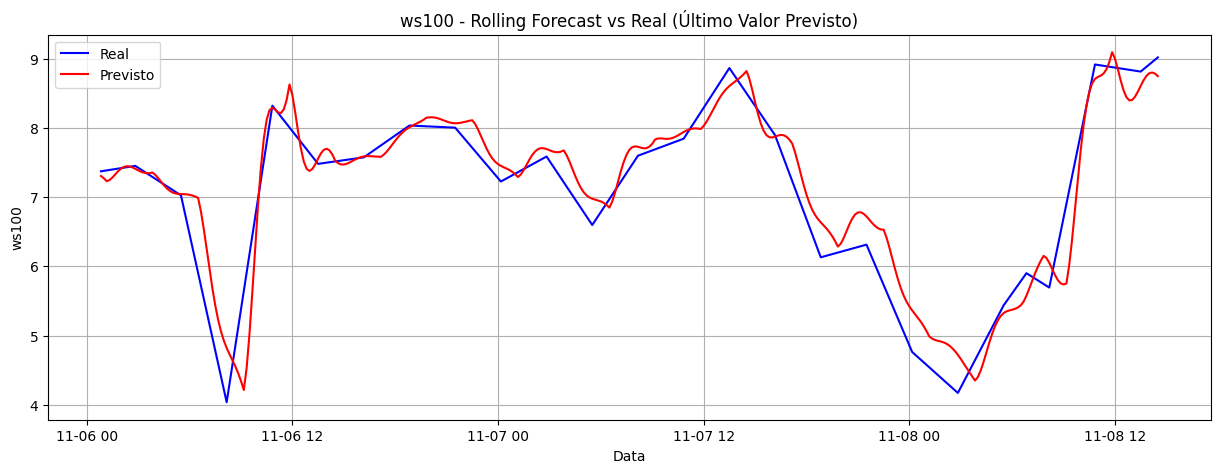

In [52]:
# %%
import os
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, TimeDistributed, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Carregamento e Pré-processamento dos Dados
data = pd.read_csv("dataset.csv")

# Verificar se a coluna 'id' existe
if 'id' not in data.columns:
    raise ValueError("A coluna 'id' não existe no dataset.")

# Converter a coluna 'id' para datetime
data['id_str'] = data['id'].astype(str).apply(lambda x: x.split('.')[0])  # Remove a parte decimal, se existir
data['id_datetime'] = pd.to_datetime(data['id_str'], errors='coerce')  # Converte para datetime

# Verificar se a conversão foi bem-sucedida
if data['id_datetime'].isnull().any():
    raise ValueError("Algumas entradas na coluna 'id' não puderam ser convertidas para datetime.")

# Definir o índice como a coluna de datetime
data.set_index('id_datetime', inplace=True)

# Remover colunas auxiliares
data.drop(columns=['id_str'], inplace=True)

# Aplicar denoising com wavelet
variables = pd.DataFrame(index=data.index)

def wavelet_denoising(signal, wavelet='bior2.2', level=4):
    coeffs = pywt.wavedec(signal, wavelet, mode='symmetric', level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeffs[1:]]
    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='symmetric')
    return reconstructed_signal[:len(signal)]

columns_to_denoise = ['ws100', 'humid', 'wdisp100', 'temp', 'vertdisp100']

for col in columns_to_denoise:
    if col in data.columns:
        denoised_signal = wavelet_denoising(data[col].values)
        variables[f'{col}_wavelet'] = denoised_signal  
    else:
        raise ValueError(f"A coluna '{col}' não existe no dataset.")

# Normalização dos Dados
scaler_ws100 = MinMaxScaler()
scaler_other = MinMaxScaler()

variables_scaled = variables.copy()

variables_scaled[['ws100_wavelet']] = scaler_ws100.fit_transform(variables[['ws100_wavelet']])
variables_scaled[['humid_wavelet', 'wdisp100_wavelet', 'temp_wavelet', 'vertdisp100_wavelet']] = scaler_other.fit_transform(
    variables[['humid_wavelet', 'wdisp100_wavelet', 'temp_wavelet', 'vertdisp100_wavelet']]
)

print(f"Forma dos dados escalados: {variables_scaled.shape}")

# %%
# 2. Criação de Sequências para o Modelo Seq2Seq com Atenção e Teacher Forcing
input_steps = 144  # Últimas 24 horas (supondo dados a cada 10 minutos)
output_steps = 6   # Próxima 1 hora (6 passos de 10 minutos)

def create_sequences(data, input_steps, output_steps, target_col_index):
    X_encoder = []
    X_decoder = []
    y_decoder = []
    for i in range(len(data) - input_steps - output_steps + 1):
        # Entrada do encoder
        X_encoder.append(data[i:(i + input_steps)])
        
        # Entrada do decoder com teacher forcing
        decoder_input = np.zeros((output_steps, 1))
        # O primeiro valor do decoder é o último valor conhecido
        decoder_input[0] = data[i + input_steps - 1, target_col_index]
        # Os demais são os valores reais deslocados
        decoder_input[1:] = data[i + input_steps:i + input_steps + output_steps - 1, target_col_index].reshape(-1, 1)
        X_decoder.append(decoder_input)
        
        # Valores alvo do decoder
        y_decoder.append(data[i + input_steps:i + input_steps + output_steps, target_col_index].reshape(-1, 1))
    return np.array(X_encoder), np.array(X_decoder), np.array(y_decoder)

data_array = variables_scaled.values
target_col_index = variables_scaled.columns.get_loc('ws100_wavelet')

X_encoder, X_decoder, y_decoder = create_sequences(data_array, input_steps, output_steps, target_col_index)

print(f"Forma de X_encoder: {X_encoder.shape}")
print(f"Forma de X_decoder: {X_decoder.shape}")
print(f"Forma de y_decoder: {y_decoder.shape}")

# Dividir em treino, validação e teste
train_end = int(X_encoder.shape[0] * 0.75)
val_end = int(X_encoder.shape[0] * 0.95)
X_encoder_train = X_encoder[:train_end]
X_decoder_train = X_decoder[:train_end]
y_decoder_train = y_decoder[:train_end]
X_encoder_val = X_encoder[train_end:val_end]
X_decoder_val = X_decoder[train_end:val_end]
y_decoder_val = y_decoder[train_end:val_end]
X_encoder_test = X_encoder[val_end:]
X_decoder_test = X_decoder[val_end:]
y_decoder_test = y_decoder[val_end:]

print(f"Treino X_encoder: {X_encoder_train.shape}, Treino X_decoder: {X_decoder_train.shape}, Treino y_decoder: {y_decoder_train.shape}")
print(f"Validação X_encoder: {X_encoder_val.shape}, Validação X_decoder: {X_decoder_val.shape}, Validação y_decoder: {y_decoder_val.shape}")
print(f"Teste X_encoder: {X_encoder_test.shape}, Teste X_decoder: {X_decoder_test.shape}, Teste y_decoder: {y_decoder_test.shape}")

# %%
# 3. Construção do Modelo Seq2Seq com Atenção e Dropout
num_encoder_features = X_encoder_train.shape[2]
num_decoder_features = 1  # Estamos prevendo apenas 'ws100_wavelet'

def build_seq2seq_attention_model(input_steps, output_steps, num_encoder_features, num_decoder_features):
    # Definir o otimizador
    optimizer = Adam(learning_rate=1e-4)
    
    # Encoder
    encoder_inputs = Input(shape=(input_steps, num_encoder_features), name='encoder_inputs')
    encoder_lstm = LSTM(64, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    # Aplicar dropout às saídas do encoder
    encoder_outputs = Dropout(0.2)(encoder_outputs)
    
    # Decoder
    decoder_inputs = Input(shape=(output_steps, num_decoder_features), name='decoder_inputs')
    decoder_lstm = LSTM(64, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
    # Aplicar dropout às saídas do decoder
    decoder_outputs = Dropout(0.2)(decoder_outputs)
    
    # Atenção
    attention_layer = Attention(name='attention_layer')
    attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
    
    # Concatenar as saídas do decoder e da atenção
    decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_outputs])
    
    # Camada de saída
    decoder_dense = TimeDistributed(Dense(1, activation='linear'), name='output_layer')
    decoder_outputs_final = decoder_dense(decoder_combined_context)
    
    # Definir o modelo
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)
    
    # Compilar o modelo
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

model = build_seq2seq_attention_model(input_steps, output_steps, num_encoder_features, num_decoder_features)
model.summary()

# %%
# 4. Treinamento do Modelo com Teacher Forcing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    [X_encoder_train, X_decoder_train], y_decoder_train, 
    epochs=200,  
    batch_size=32, 
    validation_data=([X_encoder_val, X_decoder_val], y_decoder_val),
    callbacks=callbacks,
    verbose=1
)

# %%
# 5. Avaliação do Modelo no Conjunto de Teste
# Carregar o melhor modelo
model = tf.keras.models.load_model('best_model.h5.keras', custom_objects={'Attention': Attention})
print("Melhor modelo carregado com sucesso.")

# Fazer previsões no conjunto de teste
y_pred = model.predict([X_encoder_test, X_decoder_test])

# Inversamente escalar as previsões e os valores reais
y_pred_reshaped = y_pred.reshape(-1, 1)
y_test_reshaped = y_decoder_test.reshape(-1, 1)

y_pred_inversed = scaler_ws100.inverse_transform(y_pred_reshaped).reshape(y_pred.shape)
y_test_inversed = scaler_ws100.inverse_transform(y_test_reshaped).reshape(y_decoder_test.shape)

# Calcular métricas
mae = mean_absolute_error(y_test_inversed.flatten(), y_pred_inversed.flatten())
rmse = np.sqrt(mean_squared_error(y_test_inversed.flatten(), y_pred_inversed.flatten()))
print(f"Conjunto de Teste - MAE: {mae}, RMSE: {rmse}")

# %%
# 6. Rolling Forecast no Conjunto de Teste (Prevendo Apenas o Último Valor)

def rolling_forecast(model, data, input_steps, output_steps, num_encoder_features, num_decoder_features, target_col_index):
    predictions = []
    y_true = []
    dates = []
    total_steps = len(data) - input_steps - output_steps + 1
    for i in range(total_steps):
        # Preparar a entrada do encoder
        X_encoder_input = data[i:i+input_steps].reshape(1, input_steps, num_encoder_features)
        
        # Inicializar a entrada do decoder com zeros
        decoder_input = np.zeros((1, output_steps, num_decoder_features))
        # O primeiro valor do decoder é o último valor conhecido
        decoder_input[0, 0, 0] = data[i + input_steps - 1, target_col_index]
        
        # Previsão passo a passo com Teacher Forcing (usado apenas durante o treinamento)
        # Para inferência, usamos a previsão anterior
        for t in range(1, output_steps):
            # Prever o próximo valor
            y_pred_step = model.predict([X_encoder_input, decoder_input], verbose=0)
            pred = y_pred_step[0, t-1, 0]
            # Atualizar o decoder_input com a previsão
            decoder_input[0, t, 0] = pred
        
        # Prever o último valor
        y_pred_final = model.predict([X_encoder_input, decoder_input], verbose=0)
        pred_final = y_pred_final[0, -1, 0]
        predictions.append(pred_final)
        
        # Obter o valor real correspondente
        real_value = data[i + input_steps + output_steps - 1, target_col_index]
        y_true.append(real_value)
        
        # Armazenar a data correspondente
        dates.append(variables.index[val_end + i + input_steps + output_steps - 1])
        
    return np.array(predictions), np.array(y_true), dates

# Aplicar rolling forecast
data_test = variables_scaled.values[val_end:]
predictions, y_test_full, dates = rolling_forecast(
    model, data_test, input_steps, output_steps, num_encoder_features, num_decoder_features, target_col_index
)

# Inversamente escalar
predictions_inversed = scaler_ws100.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_test_inversed = scaler_ws100.inverse_transform(y_test_full.reshape(-1, 1)).flatten()

# Calcular métricas
mae = mean_absolute_error(y_test_inversed, predictions_inversed)
rmse = np.sqrt(mean_squared_error(y_test_inversed, predictions_inversed))
print(f"Rolling Forecast - MAE: {mae}, RMSE: {rmse}")

# %%
# 7. Visualização dos Resultados

# Plotar previsões vs valores reais
plt.figure(figsize=(15, 5))
plt.plot(dates, y_test_inversed, label='Real', color='blue')
plt.plot(dates, predictions_inversed, label='Previsto', color='red')
plt.title('ws100 - Rolling Forecast vs Real (Último Valor Previsto)')
plt.xlabel('Data')
plt.ylabel('ws100')
plt.legend()
plt.grid(True)
plt.show()
